In [13]:
import numpy as np
import tempfile
import imageio
import os
import sys
import dill

from scipy.integrate import odeint
from tqdm.notebook import tqdm

dill.settings['recurse'] = True

In [14]:
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Circle
from matplotlib import animation

In [15]:
import sympy as smp

from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.solvers.solveset import linsolve

init_vprinting()

## Double Pendulum 

First, we write the Lagrangian and use the Euler-Lagrange equation to get equations of motion. ([These](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid23.ipynb) [sources](https://scipython.com/blog/the-double-pendulum/) have been very helpful.)

In [53]:
# Create Symbols:
m1, m2 = smp.symbols("m1, m2")
l1, l2 = smp.symbols("l1, l2")

g = smp.Symbol('g')
t = smp.Symbol('t')  # Creates symbolic variable t
th1, th2 = dynamicsymbols('theta_1, theta_2')

# Position Equation: r = [x, y]
r1 = np.array([l1 * smp.sin(th1), -l1 * smp.cos(th1)])  # Position of first pendulum
r2 = np.array([l2 * smp.sin(th2) + r1[0], -l2 * smp.cos(th2) + r1[1]])  # Position of second pendulum

# Velocity Equation: d/dt(r) = [dx/dt, dy/dt]
v1 = np.array([r1[0].diff(t), r1[1].diff(t)])  # Velocity of first pendulum
v2 = np.array([r2[0].diff(t), r2[1].diff(t)])  # Velocity of second pendulum

# Energy Equations:
T = 1/2 * m1 * np.dot(v1, v1) + 1/2 * m2 * np.dot(v2, v2)  # Kinetic Energy
V = m1 * g * r1[1] + m2 * g * r2[1] # Potential Energy
L = T - V  # Lagrangian
E = T + V  # Total Energy

# Replace Time Derivatives and Functions with Symbolic Variables:
dth1, dth2 = th1.diff(t), th2.diff(t)
ddth1, ddth2 = dth1.diff(t), dth2.diff(t)

# Euler-Lagrange Equations
LE1 = (L.diff(dth1).diff(t) - L.diff(th1)).simplify()
LE2 = (L.diff(dth2).diff(t) - L.diff(th2)).simplify()


In [54]:
sols = smp.solve([LE1, LE2], (ddth1, ddth2), simplify=False, rational=False)

dz1_f = smp.lambdify((t,g,m1,m2,l1,l2,th1,th2,dth1,dth2), sols[ddth1])
dz2_f = smp.lambdify((t,g,m1,m2,l1,l2,th1,th2,dth1,dth2), sols[ddth2])
dth1_f = smp.lambdify(dth1, dth1)
dth2_f = smp.lambdify(dth2, dth2)
E_f = smp.lambdify((g,m1,m2,l1,l2,th1,dth1,th2,dth2), E)

Let's save the functions we have derived for later use:

In [56]:
double_pend_funs = ["dz1_f", "dz2_f", "dth1_f", "dth2_f", "E_f"]

for fun_name in double_pend_funs:
    filename = f'double_pend/double_pend_{fun_name}'
    fun = globals()[fun_name]
    with open(filename, 'wb') as f:
        dill.dump(fun, f)

Because Python can only solve first-order ODE, we solve a system of four equations in terms of $\dot{\theta}_1, \dot{\theta}_2, \dot{z}_1, \dot{z}_2$, where $z_i = \dot{\theta}_i$.

In [52]:
class DoublePendulum:
    
    def __init__(self, m1, m2, l1, l2, state0, g=9.8, fun_dir="double_pend"):
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.state0 = state0
        self.g = g

        #loading precomputed ODE with SymPy
        self._load_sympy_funs(fun_dir)
        
    
    def _load_sympy_funs(self, fun_dir):
        double_pend_funs = ["dz1_f", "dz2_f", "dth1_f", "dth2_f", "E_f"]

        for fun_name in double_pend_funs:
            filename = os.path.join(fun_dir, f'double_pend_{fun_name}')
            with open(filename, 'rb') as f:
                fun = dill.load(f)
                setattr(self, fun_name, fun)

    
    def run(self, t_max=30, dt=0.01):
        self.t_max = t_max
        self.dt = dt
        self.t = np.arange(0, self.t_max+self.dt, self.dt)
        
        ans = odeint(
            self.integrate,
            y0=self.state0, t=self.t,
            args=(self.g,self.m1,self.m2,self.l1,self.l2)
        )
        self.th1 = ans.T[0]
        self.th2 = ans.T[2]
        
        self.x1 = self.l1*np.sin(self.th1)
        self.y1 = -self.l1*np.cos(self.th1)
        self.x2 = self.x1 + self.l2*np.sin(self.th2)
        self.y2 = self.y1 - self.l2*np.cos(self.th2) 
        
        self._check_energy_drift(ans)
                

    def _check_energy_drift(self, ans, E_drift=0.05):
        E0 = self.E_f(self.g, self.m1, self.m2, self.l1, self.l2, *self.state0)
        for i in range(len(ans)):
            E1 = self.E_f(self.g, self.m1, self.m2, self.l1, self.l2, *ans[i])
            if np.abs(E0 - E1) / E0 > E_drift:
                sys.exit(f"Something's wrong! Maximum energy drift exceeded {E_drift}")
        
        
    def plot(self, filepath=None, fps=30, max_trail=100, ns=20): 
        r0 = 0.03
        r1 = 0.01 + np.clip(self.m1, 1, 10) * 0.05
        r2 = 0.01 + np.clip(self.m2, 1, 10) * 0.05
            
        fig = plt.figure(facecolor="w", figsize=(6.25 / 2, 6.25 / 2), dpi=100)
        ax = fig.add_subplot(111)
        
        ax.set_axis_off()
        ax.set_xlim(-self.l1-self.l2-max(r1, r2), self.l1+self.l2+max(r1, r2))
        ax.set_ylim(-self.l1-self.l2-max(r1, r2), self.l1+self.l2+max(r1, r2))
        ax.set_aspect('equal', adjustable='box')
        
        self.rods, = ax.plot([], [], lw=1, c='k')
        self.trail = [ax.plot([], [], lw=1, c='r', alpha=0, solid_capstyle='butt')[0]
                      for _ in range(ns)]
        
        self.c0 = Circle((0, 0), r0/2, fc='k', zorder=10)
        self.c1 = Circle((0, 0), r1, fc='b', ec='b', zorder=10)
        self.c2 = Circle((0, 0), r2, fc='r', ec='r', zorder=10) 
        
        ax.add_patch(self.c0)
        ax.add_patch(self.c1)
        ax.add_patch(self.c2)
        
        fig.tight_layout()
        frames = tqdm(range(0, self.t.size, 1), leave=False)
        ani = animation.FuncAnimation(
            fig, self._animate, frames=frames,
            fargs=(max_trail,ns), interval=self.dt*1000/2
        )
        
        if filepath:
            ani.save(filepath, writer='pillow',fps=0.5*1/self.dt, dpi=150)                        
            
    
    def _animate(self, i, max_trail, ns):
        self.c1.center = (self.x1[i], self.y1[i])
        self.c2.center = (self.x2[i], self.y2[i])
        self.rods.set_data(
            [0, self.x1[i], self.x2[i]],
            [0, self.y1[i], self.y2[i]]
        )
        
        s = max_trail // ns
        for j in range(ns):
            imin = max(i - (ns-j)*s, 0)
            imax = imin + s + 1
                    
            alpha = (j/ns)**3
            self.trail[j].set_data(self.x2[imin:imax], self.y2[imin:imax])
            self.trail[j].set_alpha(alpha)
        
        
    def integrate(self, state, t, g, m1, m2, l1, l2):
        th1, z1, th2, z2 = state
        return [
            self.dth1_f(z1),
            self.dz1_f(t, g, m1, m2, l1, l2, th1, th2, z1, z2),
            self.dth2_f(z2),
            self.dz2_f(t, g, m1, m2, l1, l2, th1, th2, z1, z2),
        ]
    

<IPython.core.display.Javascript object>


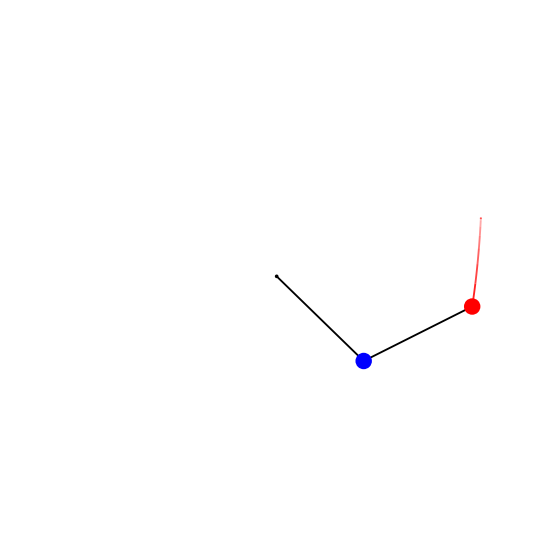

  0%|          | 0/1001 [00:00<?, ?it/s]

In [78]:
%matplotlib notebook

pend = DoublePendulum(1, 1, 1, 1, state0=[3*np.pi/7, 0, 3*np.pi/4, 0])
pend.run(t_max=40)
pend.plot()

## Triple pendulum

In [57]:
# Create Symbols:
m1, m2, m3 = smp.symbols("m1, m2, m3")
l1, l2, l3 = smp.symbols("l1, l2, l3")

g = smp.Symbol('g')
t = smp.Symbol('t')  # Creates symbolic variable t
th1, th2, th3 = dynamicsymbols('theta_1, theta_2, theta_3')

# Position Equation: r = [x, y]
r1 = np.array([l1 * smp.sin(th1), -l1 * smp.cos(th1)])  # Position of first pendulum
r2 = np.array([l2 * smp.sin(th2) + r1[0], -l2 * smp.cos(th2) + r1[1]])  # Position of second pendulum
r3 = np.array([l3 * smp.sin(th3) + r2[0], -l3 * smp.cos(th3) + r2[1]])

# Velocity Equation: d/dt(r) = [dx/dt, dy/dt]
v1 = np.array([r1[0].diff(t), r1[1].diff(t)])  # Velocity of first pendulum
v2 = np.array([r2[0].diff(t), r2[1].diff(t)])  # Velocity of second pendulum
v3 = np.array([r3[0].diff(t), r3[1].diff(t)])  # Velocity of third pendulum

# Energy Equations:
T = 1/2*m1*np.dot(v1, v1) + 1/2*m2*np.dot(v2, v2) + 1/2*m3*np.dot(v3, v3)  # Kinetic Energy
V = m1*g*r1[1] + m2*g*r2[1] + m3*g*r3[1] # Potential Energy
L = T - V  # Lagrangian
E = T + V  # Total Energy

# Replace Time Derivatives and Functions with Symbolic Variables:
dth1, dth2, dth3 = th1.diff(t), th2.diff(t), th3.diff(t)
ddth1, ddth2, ddth3 = dth1.diff(t), dth2.diff(t), dth3.diff(t)

# Euler-Lagrange Equations
LE1 = (L.diff(dth1).diff(t) - L.diff(th1)).simplify()
LE2 = (L.diff(dth2).diff(t) - L.diff(th2)).simplify()
LE3 = (L.diff(dth3).diff(t) - L.diff(th3)).simplify()


In [58]:
sols = smp.solve([LE1, LE2, LE3], (ddth1, ddth2, ddth3), simplify=False, rational=False)

dz1_f = smp.lambdify((t,g,m1,m2,m3,l1,l2,l3,th1,th2,th3,dth1,dth2,dth3), sols[ddth1])
dz2_f = smp.lambdify((t,g,m1,m2,m3,l1,l2,l3,th1,th2,th3,dth1,dth2,dth3), sols[ddth2])
dz3_f = smp.lambdify((t,g,m1,m2,m3,l1,l2,l3,th1,th2,th3,dth1,dth2,dth3), sols[ddth3])

dth1_f = smp.lambdify(dth1, dth1)
dth2_f = smp.lambdify(dth2, dth2)
dth3_f = smp.lambdify(dth3, dth3)

E_f = smp.lambdify((g,m1,m2,m3,l1,l2,l3,th1,dth1,th2,dth2,th3,dth3), E)

Let's save the functions we have derived for later use:

In [59]:
triple_pend_funs = ["dz1_f", "dz2_f", "dz3_f", "dth1_f", "dth2_f", "dth3_f", "E_f"]

for fun_name in triple_pend_funs:
    filename = f'triple_pend/triple_pend_{fun_name}'
    fun = globals()[fun_name]
    with open(filename, 'wb') as f:
        dill.dump(fun, f)

In [79]:
class TriplePendulum:
    
    def __init__(self, m1, m2, m3, l1, l2, l3, state0, g=9.8, fun_dir="triple_pend"):
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        
        self.state0 = state0
        self.g = g 

        #loading precomputed ODE with SymPy
        self._load_sympy_funs(fun_dir)

    
    def _load_sympy_funs(self, fun_dir):
        triple_pend_funs = ["dz1_f", "dz2_f", "dz3_f", "dth1_f", "dth2_f", "dth3_f", "E_f"]

        for fun_name in triple_pend_funs:
            filename = os.path.join(fun_dir, f'triple_pend_{fun_name}')
            with open(filename, 'rb') as f:
                fun = dill.load(f)
                setattr(self, fun_name, fun)
    
    
    def run(self, t_max=30, dt=0.01):
        self.t_max = t_max
        self.dt = dt
        self.t = np.arange(0, self.t_max+self.dt, self.dt)
        
        ans = odeint(
            self.integrate,
            y0=self.state0, t=self.t,
            args=(self.g,self.m1,self.m2,self.m3,self.l1,self.l2,self.l3)
        )
        self.th1 = ans.T[0]
        self.th2 = ans.T[2]
        self.th3 = ans.T[4]
        
        self.x1 = self.l1*np.sin(self.th1)
        self.y1 = -self.l1*np.cos(self.th1)
        self.x2 = self.x1 + self.l2*np.sin(self.th2)
        self.y2 = self.y1 - self.l2*np.cos(self.th2)
        self.x3 = self.x2 + self.l3*np.sin(self.th3)
        self.y3 = self.y2 - self.l3*np.cos(self.th3)
        
        self._check_energy_drift(ans)
                

    def _check_energy_drift(self, ans, E_drift=0.05):
        E0 = self.E_f(self.g, self.m1, self.m2, self.m3, self.l1, self.l2, self.l3, *self.state0)
        for i in range(len(ans)):
            E1 = self.E_f(self.g, self.m1, self.m2, self.m3, self.l1, self.l2, self.l3, *ans[i])
            if np.abs(E0 - E1) / E0 > E_drift:
                sys.exit(f"Something's wrong! Maximum energy drift exceeded {E_drift}")
        
        
    def plot(self, filepath=None, fps=30, max_trail=100, ns=20): 
        r0 = 0.03
        r1 = 0.01 + np.clip(self.m1, 1, 10) * 0.05
        r2 = 0.01 + np.clip(self.m2, 1, 10) * 0.05
        r3 = 0.01 + np.clip(self.m3, 1, 10) * 0.05
            
        fig = plt.figure(facecolor="w", figsize=(6.25 / 2, 6.25 / 2), dpi=100)
        ax = fig.add_subplot(111)
        
        ax.set_axis_off()
        lim = self.l1+self.l2+self.l3+max(r1, r2, r3)
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_aspect('equal', adjustable='box')
        
        self.rods, = ax.plot([], [], lw=1, c='k')
#         self.trail1 = [ax.plot([], [], lw=1, c='b', alpha=0, solid_capstyle='butt')[0]
#                        for _ in range(ns)]
        self.trail2 = [ax.plot([], [], lw=1, c='r', alpha=0, solid_capstyle='butt')[0]
                       for _ in range(ns)]
        self.trail3 = [ax.plot([], [], lw=1, c='g', alpha=0, solid_capstyle='butt')[0]
                       for _ in range(ns)]
        
        self.c0 = Circle((0, 0), r0/2, fc='k', zorder=10)
        self.c1 = Circle((0, 0), r1, fc='b', ec='b', zorder=10)
        self.c2 = Circle((0, 0), r2, fc='r', ec='r', zorder=10)
        self.c3 = Circle((0, 0), r3, fc='g', ec='g', zorder=10) 
        
        ax.add_patch(self.c0)
        ax.add_patch(self.c1)
        ax.add_patch(self.c2)
        ax.add_patch(self.c3)
        
        fig.tight_layout()
        frames = tqdm(range(0, self.t.size, 1), leave=False)
        
        self.ani = animation.FuncAnimation(
            fig, self._animate, frames=frames,
            fargs=(max_trail,ns), interval=self.dt*1000/2
        )
        
        if filepath:
            self.ani.save('test.gif',writer='pillow',fps=0.5*1/self.dt, dpi=150)                        
            
    
    def _animate(self, i, max_trail, ns):
        self.c1.center = (self.x1[i], self.y1[i])
        self.c2.center = (self.x2[i], self.y2[i])
        self.c3.center = (self.x3[i], self.y3[i])
        
        self.rods.set_data(
            [0, self.x1[i], self.x2[i], self.x3[i]],
            [0, self.y1[i], self.y2[i], self.y3[i]]
        )
        
        s = max_trail // ns
        for j in range(ns):
            imin = max(i - (ns-j)*s, 0)
            imax = imin + s + 1   
            
            alpha = (j/ns)**3
#             self.trail1[j].set_data(self.x1[imin:imax], self.y1[imin:imax])
#             self.trail1[j].set_alpha(alpha)
            self.trail2[j].set_data(self.x2[imin:imax], self.y2[imin:imax])
            self.trail2[j].set_alpha(alpha)
            self.trail3[j].set_data(self.x3[imin:imax], self.y3[imin:imax])
            self.trail3[j].set_alpha(alpha)
        
        
    def integrate(self, state, t, g, m1, m2, m3, l1, l2, l3):
        th1, z1, th2, z2, th3, z3 = state
        return [
            self.dth1_f(z1),
            self.dz1_f(t, g, m1, m2, m3, l1, l2, l3, th1, th2, th3, z1, z2, z3),
            self.dth2_f(z2),
            self.dz2_f(t, g, m1, m2, m3, l1, l2, l3, th1, th2, th3, z1, z2, z3),
            self.dth3_f(z3),
            self.dz3_f(t, g, m1, m2, m3, l1, l2, l3, th1, th2, th3, z1, z2, z3),
        ]
    

<IPython.core.display.Javascript object>


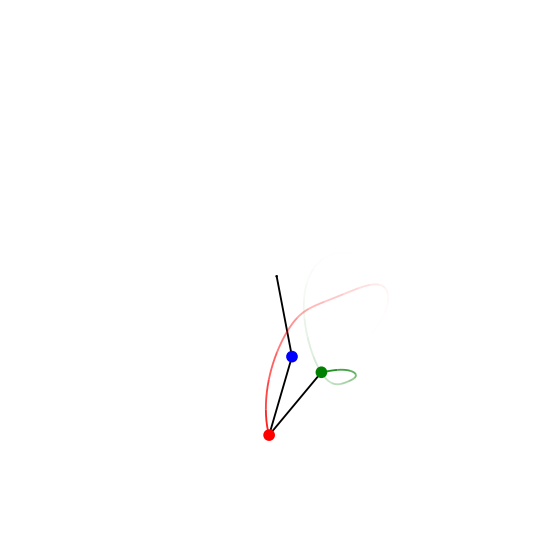

  0%|          | 0/4001 [00:00<?, ?it/s]

In [80]:
%matplotlib notebook

pend = TriplePendulum(1, 1, 1, 1, 1, 1, state0=[3*np.pi/7, 0, 3*np.pi/4, 0, 3*np.pi/4, 0])
pend.run(t_max=40)
pend.plot()
